In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, accuracy_score
import csv, pandas, re
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression

from sklearn.feature_selection import RFE

from google.colab import drive
 
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras import regularizers
from keras import optimizers

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [2]:
# Импортирование ДН(359) и углов нарезки щелей(89) из CSV файла после расчета в HFSS

def data_preprocessing(path):   
    csv_conc=pd.DataFrame()
    csv_export_temp=pd.read_csv(path, delimiter = ",")
    csv_export_temp.index=csv_export_temp.iloc[:,0]
    csv_export_temp=csv_export_temp.iloc[:,2:]
    csv_conc=pd.concat([csv_conc,csv_export_temp],axis=1)
    csv_export_indexes=list(csv_conc) # Индексы (т.е. углы)
    
    csv_export_temp=list(range(359))
    angles_temp_one_iter=list(range(89))
    csv_export_temp=list(range(len(csv_export_indexes)))
    angles_minus_sort=list(range(89))
    angles_general_list=pd.DataFrame()
    
    for k in range(len(csv_export_indexes)):
        csv_export_temp=re.findall(r'[^ang\d{1,2}]\d{1,2}.[^deg]*',csv_export_indexes[k])            
        del csv_export_temp[89:92]
        for i in range(89):
            if i%11==0:
                angles_temp_one_iter[int(i//11)]=csv_export_temp[i]            
            elif 1<=i<=10:
                angles_temp_one_iter[i+8]=csv_export_temp[i]
            elif 12<=i<=87:      
                angles_temp_one_iter[i+(8-(i//11))]=csv_export_temp[i]
        for i in range(89):     #     
            if angles_temp_one_iter[i][0]!='-':
                angles_minus_sort[i]=angles_temp_one_iter[i][1:]
            else:
                angles_minus_sort[i]=angles_temp_one_iter[i][:]
            angles_general_list[k]=(np.array([float(x) for x in (angles_minus_sort)]))
    angles=(pd.DataFrame(angles_general_list)).T
    amplitude=csv_conc.T
    return angles, amplitude

angles, amplitude=data_preprocessing("/content/drive/MyDrive/concat_all_90.csv")

('X_train:', (1460, 369))
('X_test:', (163, 369))
('y_train:', (1460,))
('y_test:', (163,))
('X_valid:', (2, 369))
('y_valid:', (2,))
Epoch 1/15
365/365 [==============================] - 2s 3ms/step - loss: 1.2005 - mae: 0.8007 - val_loss: 0.2485 - val_mae: 0.3595
Epoch 2/15
365/365 [==============================] - 1s 2ms/step - loss: 0.2512 - mae: 0.3629 - val_loss: 0.2209 - val_mae: 0.3459
Epoch 3/15
365/365 [==============================] - 1s 2ms/step - loss: 0.1442 - mae: 0.2822 - val_loss: 0.1958 - val_mae: 0.3237
Epoch 4/15
365/365 [==============================] - 1s 2ms/step - loss: 0.0960 - mae: 0.2120 - val_loss: 0.1941 - val_mae: 0.3350
Epoch 5/15
365/365 [==============================] - 1s 2ms/step - loss: 0.0774 - mae: 0.2089 - val_loss: 0.1819 - val_mae: 0.3201
Epoch 6/15
365/365 [==============================] - 1s 2ms/step - loss: 0.0728 - mae: 0.1986 - val_loss: 0.1848 - val_mae: 0.3256
Epoch 7/15
365/365 [==============================] - 1s 2ms/step - loss: 

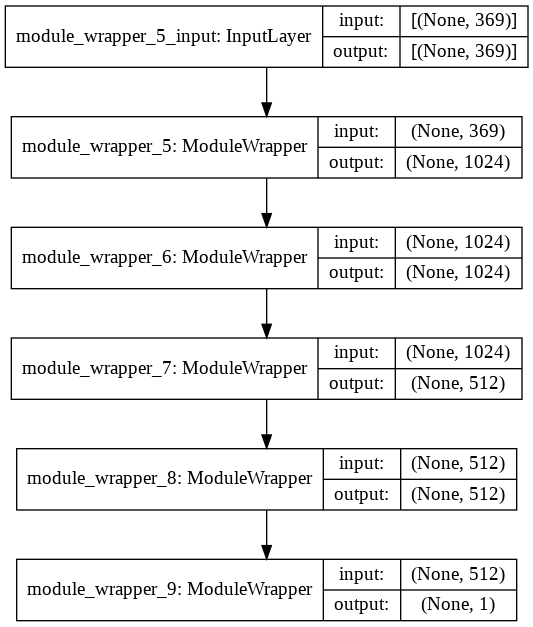

In [5]:
scaler=RobustScaler()
scaler.fit(amplitude)
X_scaled = scaler.transform(amplitude)
X_scaled_sliced=X_scaled[:1625,(90-60):(90+60)]
angles_sliced=angles.iloc[:1625,:]



poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_scaled_sliced)
X_poly = pd.DataFrame(poly.transform(X_scaled_sliced))


select = SelectPercentile(f_regression,percentile=5)
select.fit(X_poly, angles_sliced.iloc[:,2])
X_poly = select.transform(X_poly)


X_val, X_test, y_val, y_test = train_test_split(X_poly,  angles_sliced.iloc[:,2], test_size=0.1, random_state=20)
X_train, X_valid, y_train, y_valid = train_test_split(X_val,  y_val, test_size=0.001, random_state=20)



print(('X_train:',np.shape(X_train)),\
      ('X_test:',np.shape(X_test)),\
      ('y_train:',np.shape(y_train)),\
      ('y_test:',np.shape(y_test)),\
      ('X_valid:', np.shape(X_valid)),\
      ('y_valid:',np.shape(y_valid)),sep='\n')



model = models.Sequential()

model.add(layers.Dense(1024,kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.01),input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.01), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))


optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='mse',      
              metrics=['mae'])  
model.fit(X_train, y_train, epochs=15, batch_size=4,validation_data=(X_test, y_test))

model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
y_predicted= model.predict(X_valid)
print(("y_valid",y_valid),\
      ("y_predicted",y_predicted))

('y_valid', 1504   -0.662583
933    -0.226301
Name: 3, dtype: float64) ('y_predicted', array([[-0.532335  ],
       [-0.36737984]], dtype=float32))
